In [32]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy.stats as stats

In [33]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

## 数据预处理

In [34]:
def load(path, info=True):
    # 导入所需的模块
    import pandas as pd
    import io
    
    # 根据文件扩展名读取数据
    if len(path.split(".csv")) > 1:
        # 如果是CSV文件，使用read_csv读取
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        # 如果是Excel文件，使用read_excel读取
        read = pd.read_excel(path)
    
    # 如果info参数为True，则打印数据集的详细信息
    if info:
        # 检查数据是否已成功导入
        if len(read) > 0:
            print("# Data imported!")
            print("# ------------------------------------", "\n")
        
            # 打印数据的维度信息
            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
    
            # 根据数据类型打印不同类型的变量信息
            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            # 检查数据中是否有缺失值
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False, 
                                                            "No missing value!", "Data includes missing value!"), "\n")
            
            # 使用io.StringIO获取DataFrame.info()的输出
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            
            # 打印内存使用信息
            print("# MEMORY USAGE ---------------------- \n", info)
          
        else:
            print("# Data did not import!")
    
    # 返回读取的数据
    return read


In [35]:
path = "ab_test.csv"
ab = load(path, info = True)
ab

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 120000 Column: 4 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 1 
 ['group'] 

Integer Variables: 
 # of Variables: 1 
 ['user_id'] 

Float Variables: 
 # of Variables: 2 
 ['views', 'clicks'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 3.7+ MB


,user_id,group,views,clicks
0,1,control,10.0000,0.0000
1,2,control,1.0000,0.0000
2,3,control,1.0000,0.0000
3,4,control,2.0000,0.0000
4,5,control,3.0000,0.0000
...,...,...,...,...
119995,119996,test,9.0000,0.0000
119996,119997,test,2.0000,1.0000
119997,119998,test,20.0000,1.0000
119998,119999,test,6.0000,1.0000


In [36]:
# 选取用户样本
# 了解用户观看数据
print(ab.user_id.nunique() == ab.shape[0])
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["views"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
views,120000.0000,4.9911,5.9152,1.0000,1.0000,1.0000,1.0000,2.0000,3.0000,7.0000,10.0000,15.0000,28.0000,205.0000


In [37]:
# 了解用户点击数据
print(ab.user_id.nunique() == ab.shape[0])
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["clicks"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
clicks,120000.0000,0.1827,0.4725,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,2.0000,9.0000


In [38]:
ab.groupby("group").views.agg(["count", "median", "mean", "std", "max"])
ab.groupby("group").clicks.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
group,,,,,
control,60000,0.0000,0.1717,0.4538,7.0000
test,60000,0.0000,0.1937,0.4903,9.0000


## 可视化分析

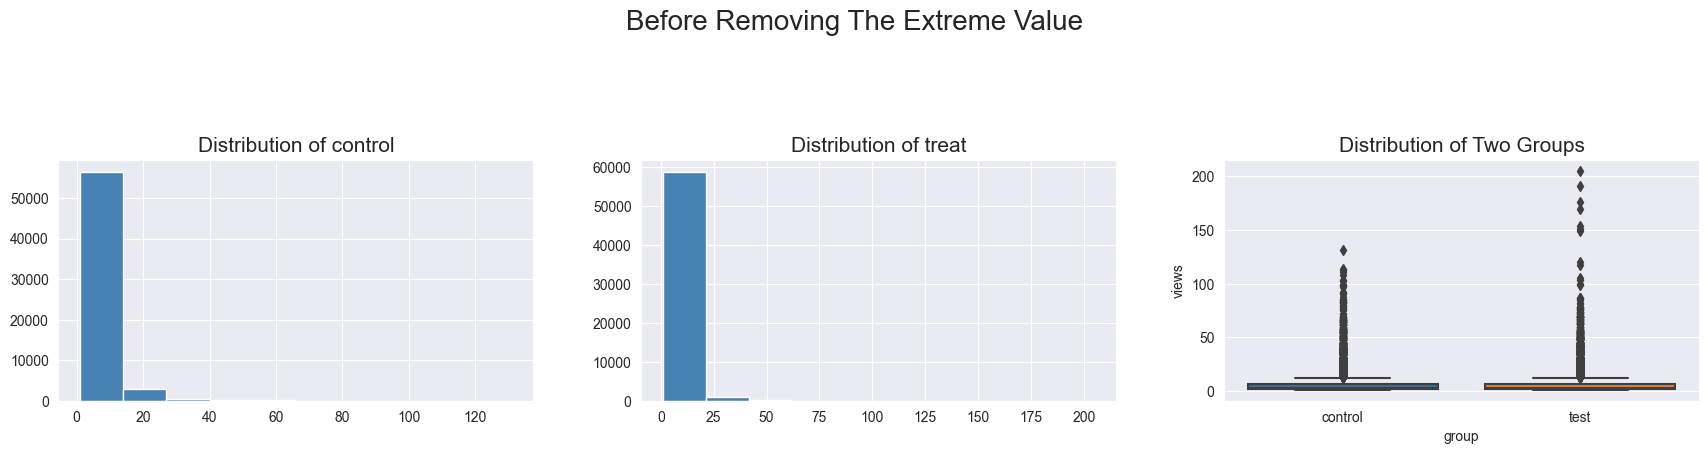

In [39]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
ab[(ab.group == "control")].hist("views", ax = axes[0], color = "steelblue")
ab[(ab.group == "test")].hist("views", ax = axes[1], color = "steelblue")
sns.boxplot(x = ab.group, y = ab.views, ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of control", fontsize = 15)
axes[1].set_title("Distribution of treat", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

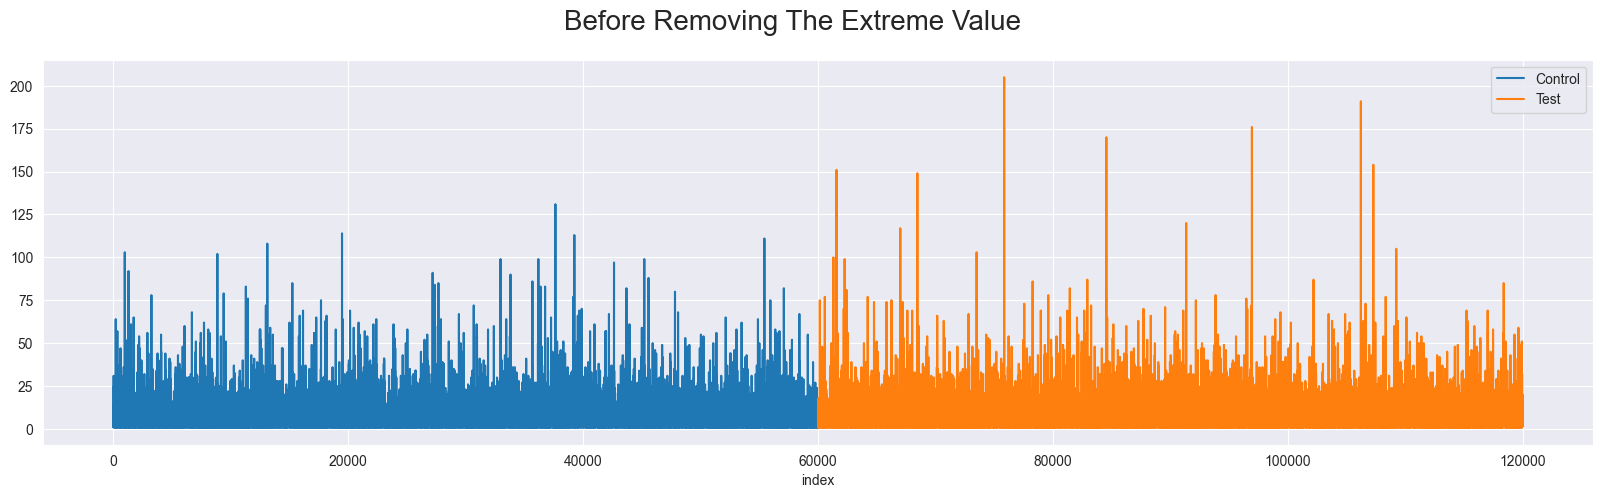

In [40]:
ab[ab.group == "control"].reset_index().set_index("index").views.plot(legend = True, label = "Control", figsize = (20,5))
ab[ab.group == "test"].reset_index().set_index("index").views.plot(legend = True, label = "Test")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20);

In [41]:
ab["group"] = np.where(ab.group == "control", "A", "B")
ab

,user_id,group,views,clicks
0,1,A,10.0000,0.0000
1,2,A,1.0000,0.0000
2,3,A,1.0000,0.0000
3,4,A,2.0000,0.0000
4,5,A,3.0000,0.0000
...,...,...,...,...
119995,119996,B,9.0000,0.0000
119996,119997,B,2.0000,1.0000
119997,119998,B,20.0000,1.0000
119998,119999,B,6.0000,1.0000


## 使用t-test进行AB test运算

In [42]:
def AB_Test(dataframe, group, target):
    import scipy.stats as stats
    import pandas as pd
    
    # 分割数据
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]

    # 独立样本 t 检验
    ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]

    # 结果汇总
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = "T-test"
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    temp = temp[["Test Type", "AB Hypothesis", "p-value", "Comment"]]
    
    # 打印假设
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp


In [43]:
AB_Test(dataframe=ab, group = "group", target = "views")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 


,Test Type,AB Hypothesis,p-value,Comment
0,T-test,Reject H0,0.0235,A/B groups are not similar!
